In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold

# Functions from the main experiments
from main import classifiers
from main import score_types
from data_wrappers.datasets import Data
from calib.utils.calibration import cv_calibration
from calib.utils.functions import get_sets

# Functions for the synthetic data
from probability_distributions import Dirichlet
from probability_distributions import MixtureDistribution

# Plots on barycentric choordinates
from barycentric import draw_tri_samples
from barycentric import draw_pdf_contours
from barycentric import draw_func_contours
from barycentric import plot_individual_pdfs
from barycentric import plot_marginal
from barycentric import get_mesh_bc
from barycentric import plot_converging_lines_pvalues
from barycentric import get_converging_lines

# For barycentric grid size (higher values are computationally more expensive)
nlevels=100
subdiv=8

# For all random number generators
seed = 42

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Calibration methods to compare

In [2]:
methods = [None, 'beta', 'isotonic', 'dirichlet_full',
           'dirichlet_diag', 'dirichlet_fix_diag',
           #'dirichlet_mixture'
          ]

# Synthetic Dirichlet distribution

In [21]:
class_dist = MixtureDistribution([0.33, 0.33, 0.34], 
                                  (Dirichlet([2, 1, 1]),     
                                   Dirichlet([1, 5, 2]), 
                                   Dirichlet([3, 4, 10])))

print(class_dist)

prior = 0.33, Distribution = [2,1,1]
prior = 0.33, Distribution = [1,5,2]
prior = 0.34, Distribution = [ 3, 4,10]



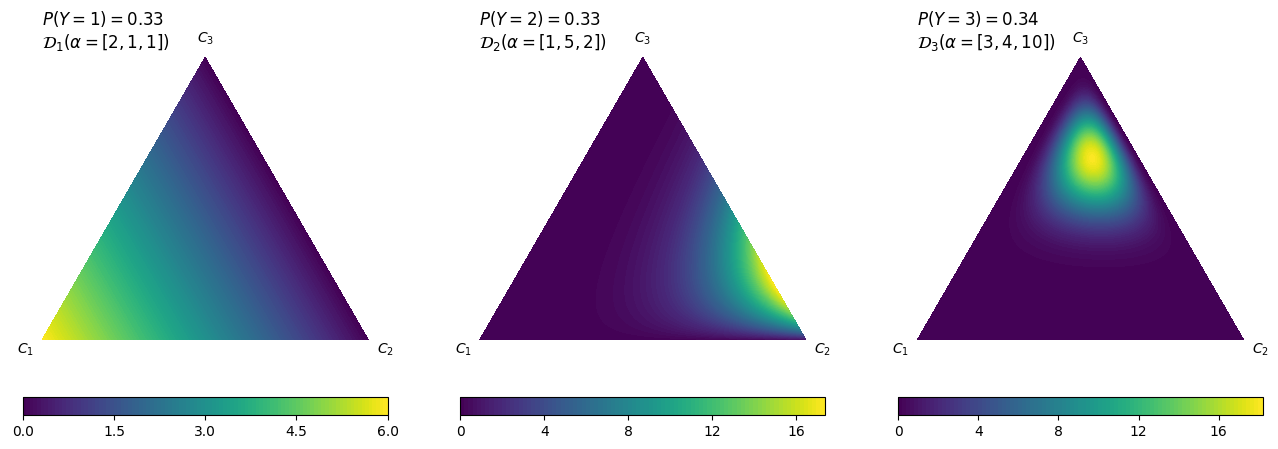

In [22]:
plot_individual_pdfs(class_dist, nlevels=nlevels, subdiv=subdiv)

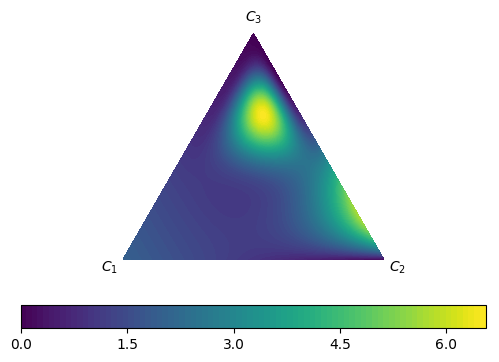

In [24]:
draw_pdf_contours(class_dist, labels='auto', nlevels=nlevels, subdiv=subdiv)

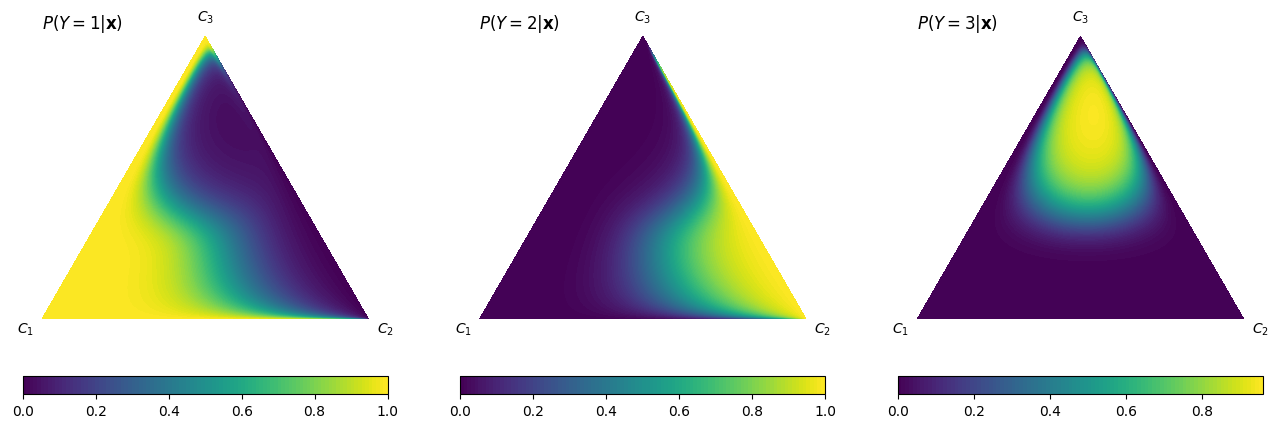

In [25]:
fig = plt.figure(figsize=(16, 5))
for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.6format(i+1), loc='left')
    
    class_dist.pdf = lambda x: class_dist.posterior(x, i)
    draw_pdf_contours(class_dist, labels='auto', fig=fig, ax=ax, nlevels=nlevels, subdiv=subdiv)

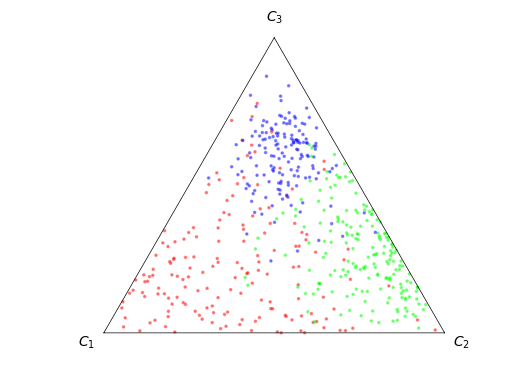

In [26]:
N = 500
scores, classes = class_dist.sample(N)

draw_tri_samples(scores, classes, s=10, marker='.', alpha=0.4)

# Test different calibration methods

- We will use as a initial classifier a mock class that only outputs the given input

In [27]:
classifier_name = 'mock'

classifier = classifiers[classifier_name]
score_type = score_types[classifier_name]
# TODO we should shuffle the datasets here
X = scores
Y = classes
y = Y.argmax(axis=1)
evaluation_folds = 2
calibration_folds = 2

skf = StratifiedKFold(y, n_folds=evaluation_folds, shuffle=True, random_state=seed)
test_folds = skf.test_folds
test_fold = 0

x_train, y_train, x_test, y_test = get_sets(X, y, test_fold, test_folds)   

In [28]:
accs, losses, briers, mean_probas, cl = cv_calibration(
    classifier, methods, x_train, y_train, x_test, y_test, 
    cv=calibration_folds, score_type=score_type, model_type='full-stack',
    verbose=0, seed=seed)

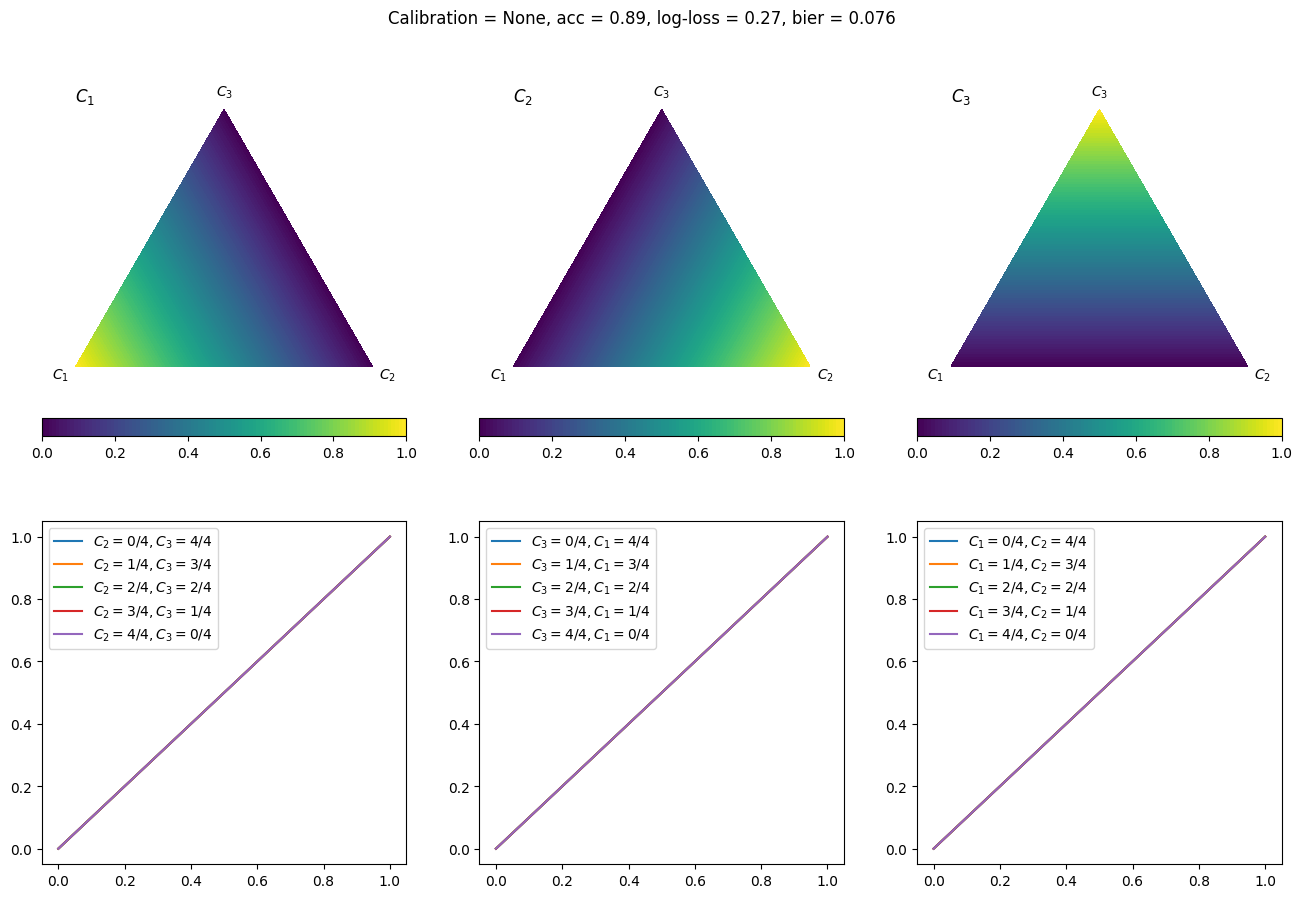

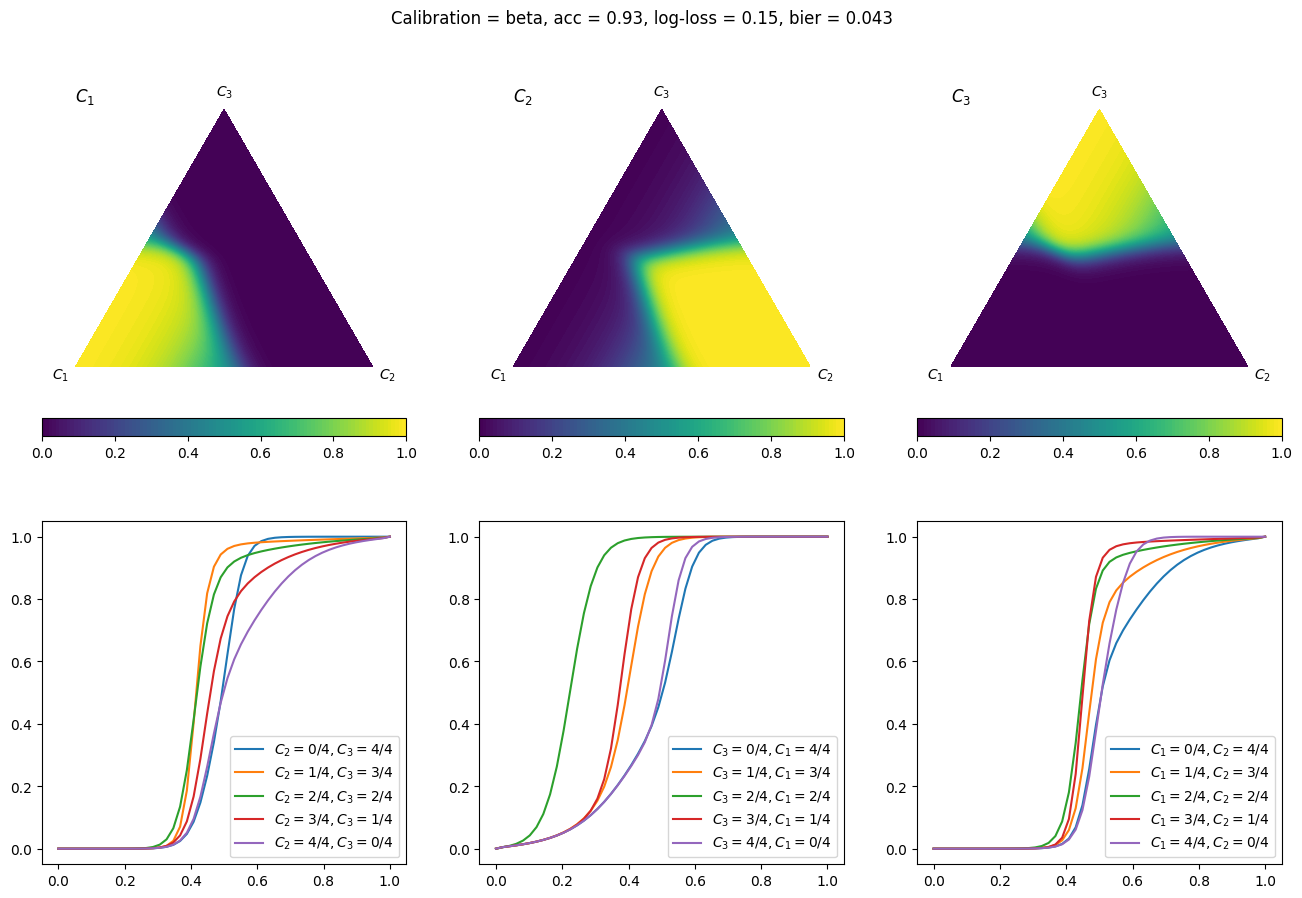

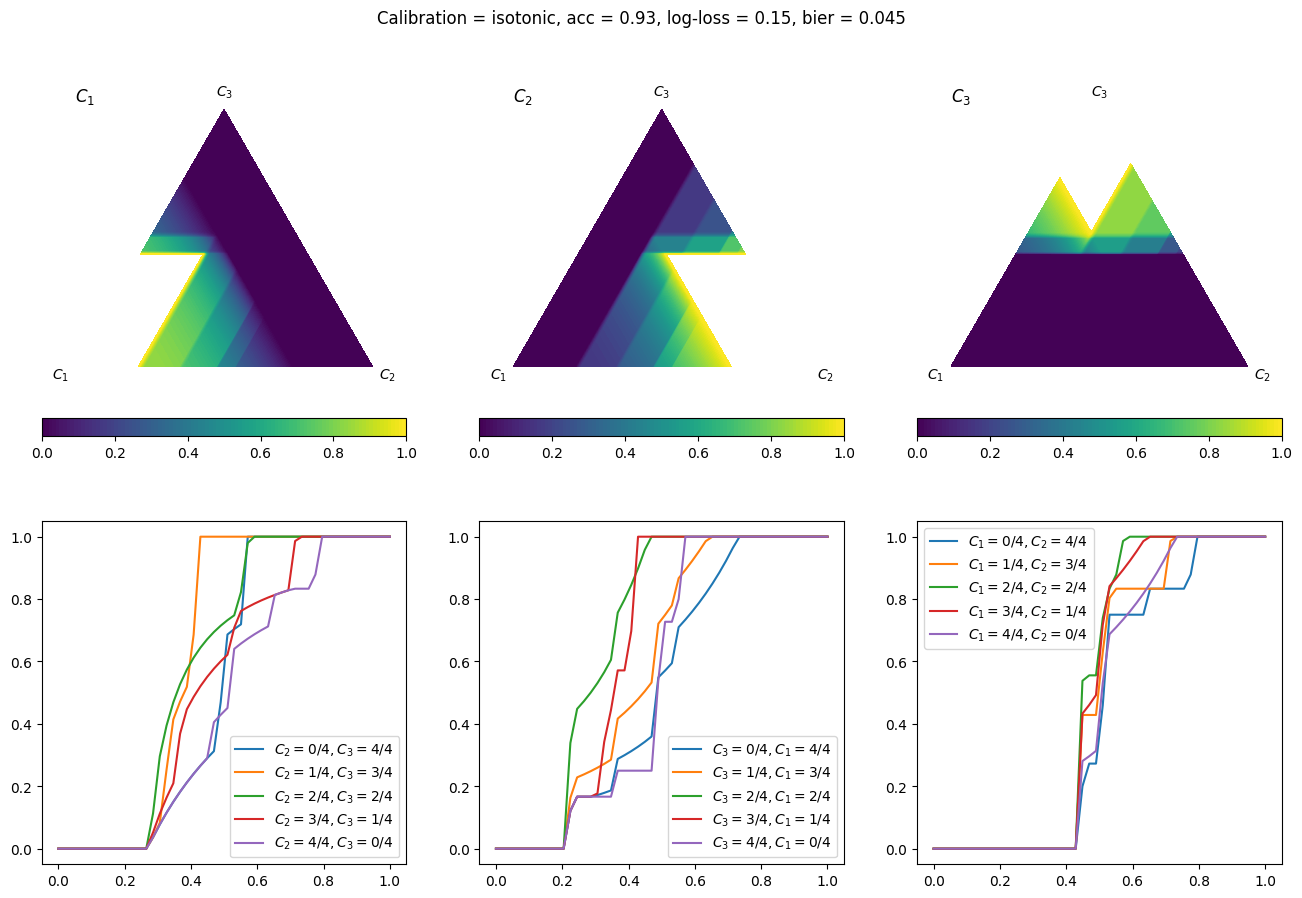

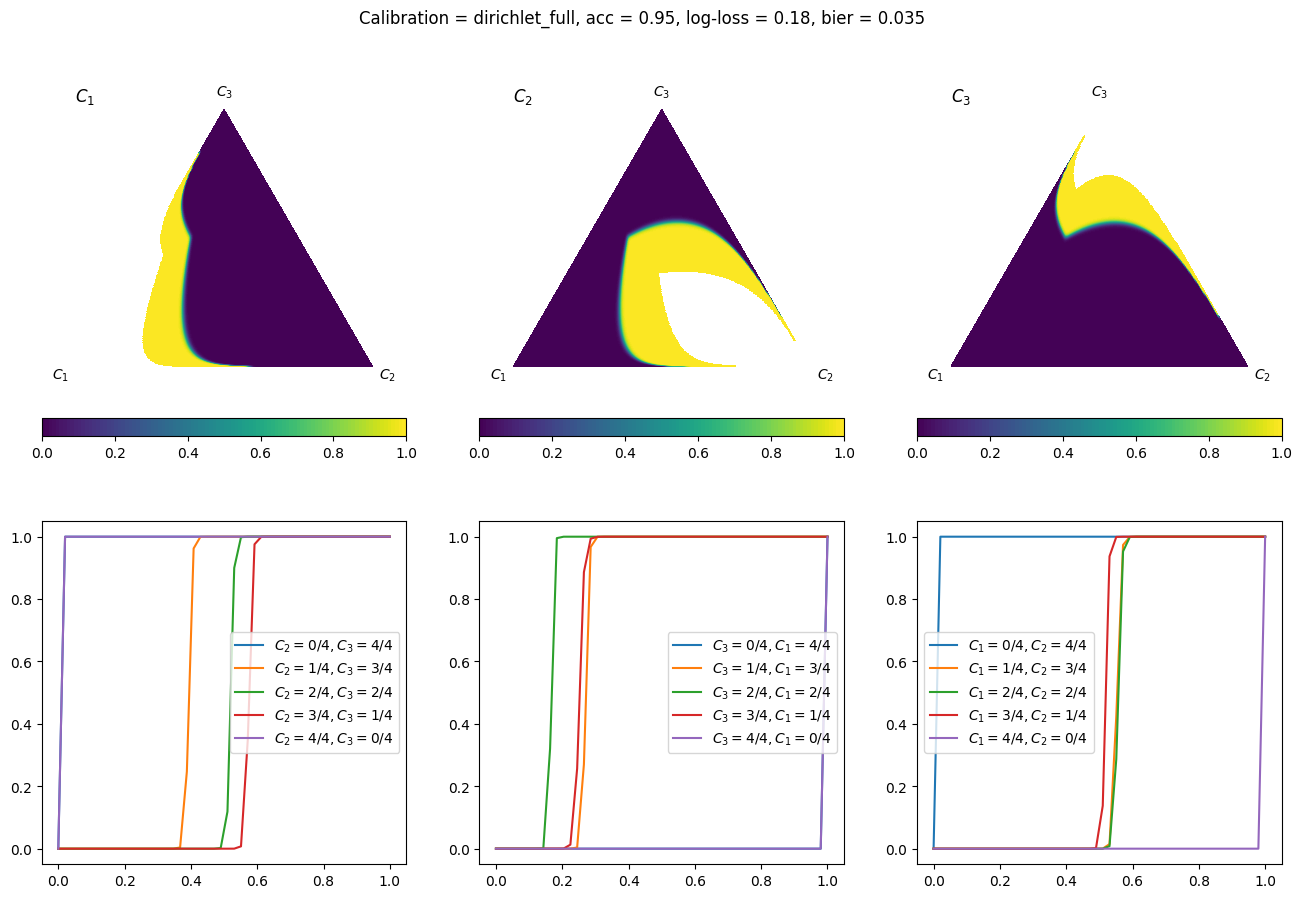

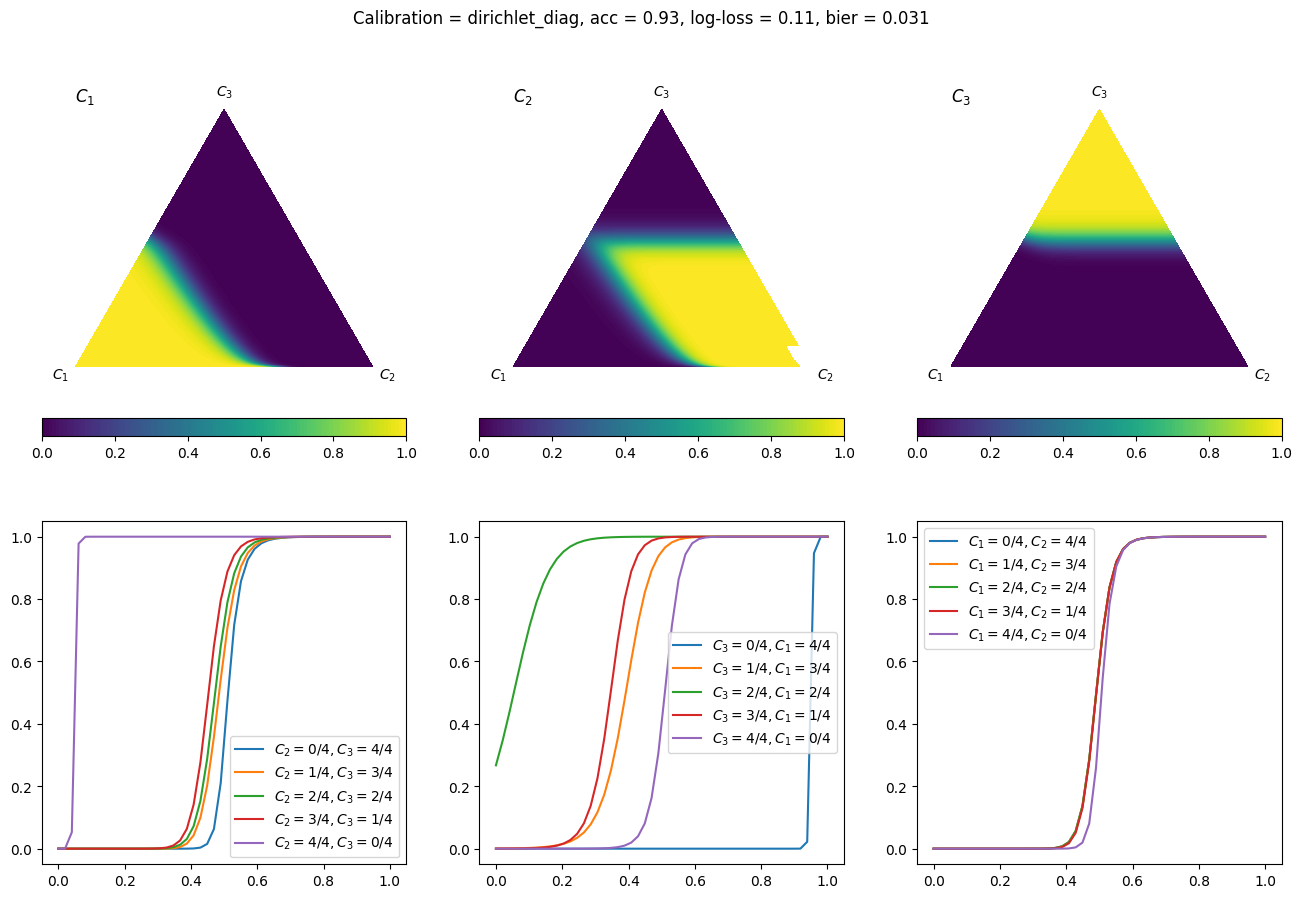

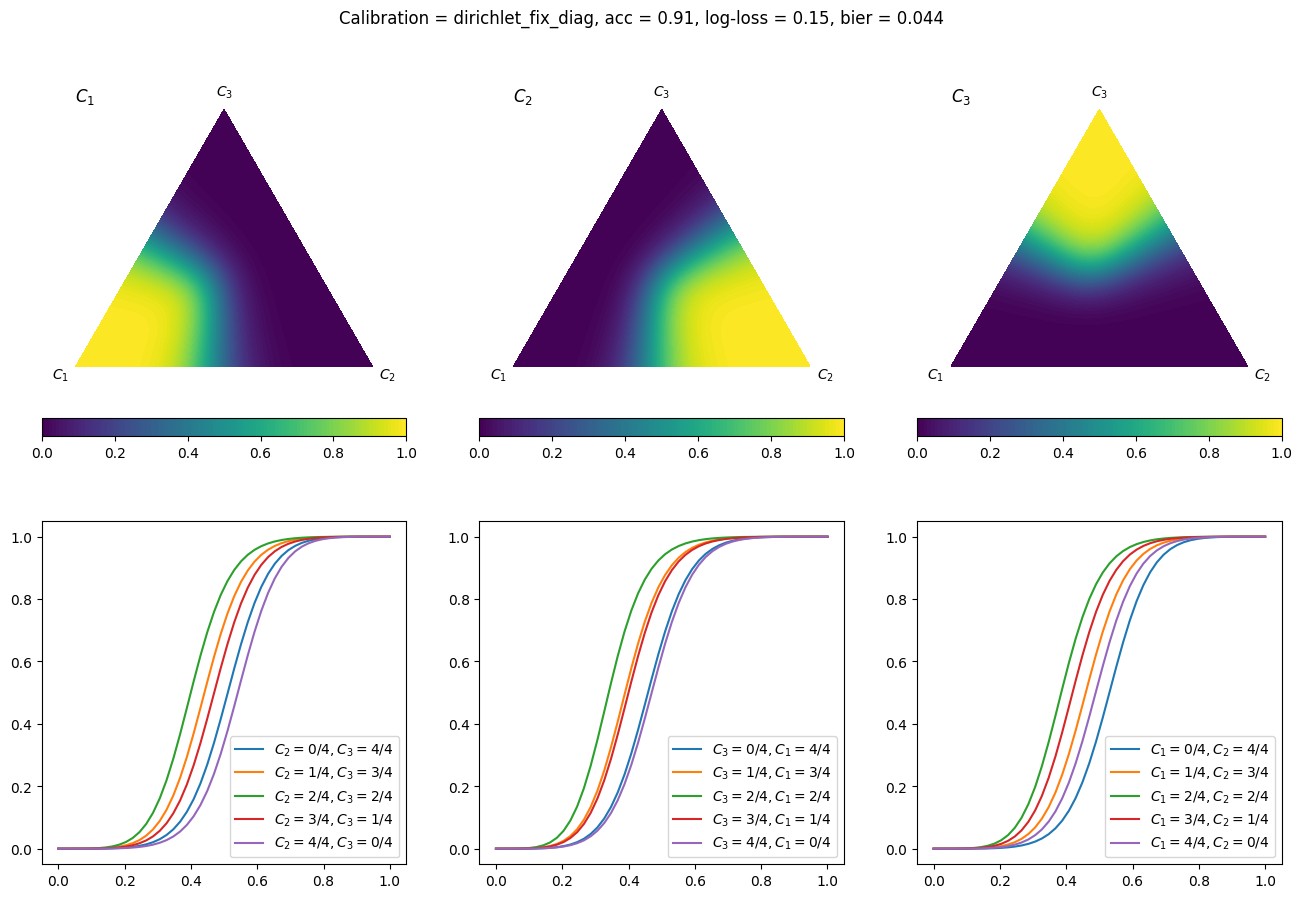

In [35]:
mesh = get_mesh_bc(nlevels=nlevels, subdiv=subdiv)

for method in methods:
    calibrator = cl[method][0].calibrator
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Calibration = {}, acc = {:.2}, log-loss = {:.2}, bier = {:.2}'.format(
        method, accs[method], losses[method], briers[method]))

    for i, c in enumerate(['C1', 'C2', 'C3']):
        ax = fig.add_subplot(2, 3, i+1)

        ax.set_title('$C_{}$'.format(i+1), loc='left')

        function = lambda x: calibrator.predict_proba(x.reshape(1,-1))[0][i]
        draw_func_contours(function, labels='auto', fig=fig, ax=ax, nlevels=nlevels, subdiv=subdiv)
        
        ax2 = fig.add_subplot(2, 3, 3+i+1)
    
        #function = lambda x: class_dist.posterior(x, i).reshape(-1,1)
        lines = get_converging_lines(num_lines=5, mesh_precision=50, class_index=i)
        plot_converging_lines_pvalues(function, lines, i, ax2)
    
        #ax3 = fig.add_subplot(4, 3, 6+i+1)
        #ax4 = fig.add_subplot(4, 3, 9+i+1)
        #plot_marginal(function, mesh, c, ax3, ax4)

# With a real dataset and a classifier

In [31]:
classifier_name = 'logistic'
classifier = classifiers[classifier_name]
score_type = score_types[classifier_name]
# TODO we should shuffle the datasets here
data = Data(dataset_names=['iris'])
dataset = data.datasets['iris']
evaluation_folds = 2
calibration_folds = 2

skf = StratifiedKFold(dataset.target, n_folds=evaluation_folds, shuffle=True, random_state=seed)
test_folds = skf.test_folds
test_fold = 0

x_train, y_train, x_test, y_test = get_sets(dataset.data, dataset.target, test_fold, test_folds)   

In [32]:
accs, losses, briers, mean_probas, cl = cv_calibration(
    classifier, methods, x_train, y_train, x_test, y_test, 
    cv=calibration_folds, score_type=score_type, model_type='full-stack',
    verbose=0, seed=seed)

# Draw test samples and classifier prediction

In [13]:
calibrator = cl[None][0]
scores = mean_probas[None]
classes = y_test

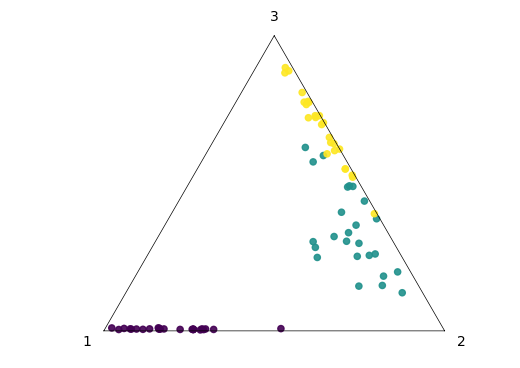

In [14]:
draw_tri_samples(scores, classes, labels=dataset.names, s=20, marker='o', alpha=0.9)

## Prediction space per Calibrator and class

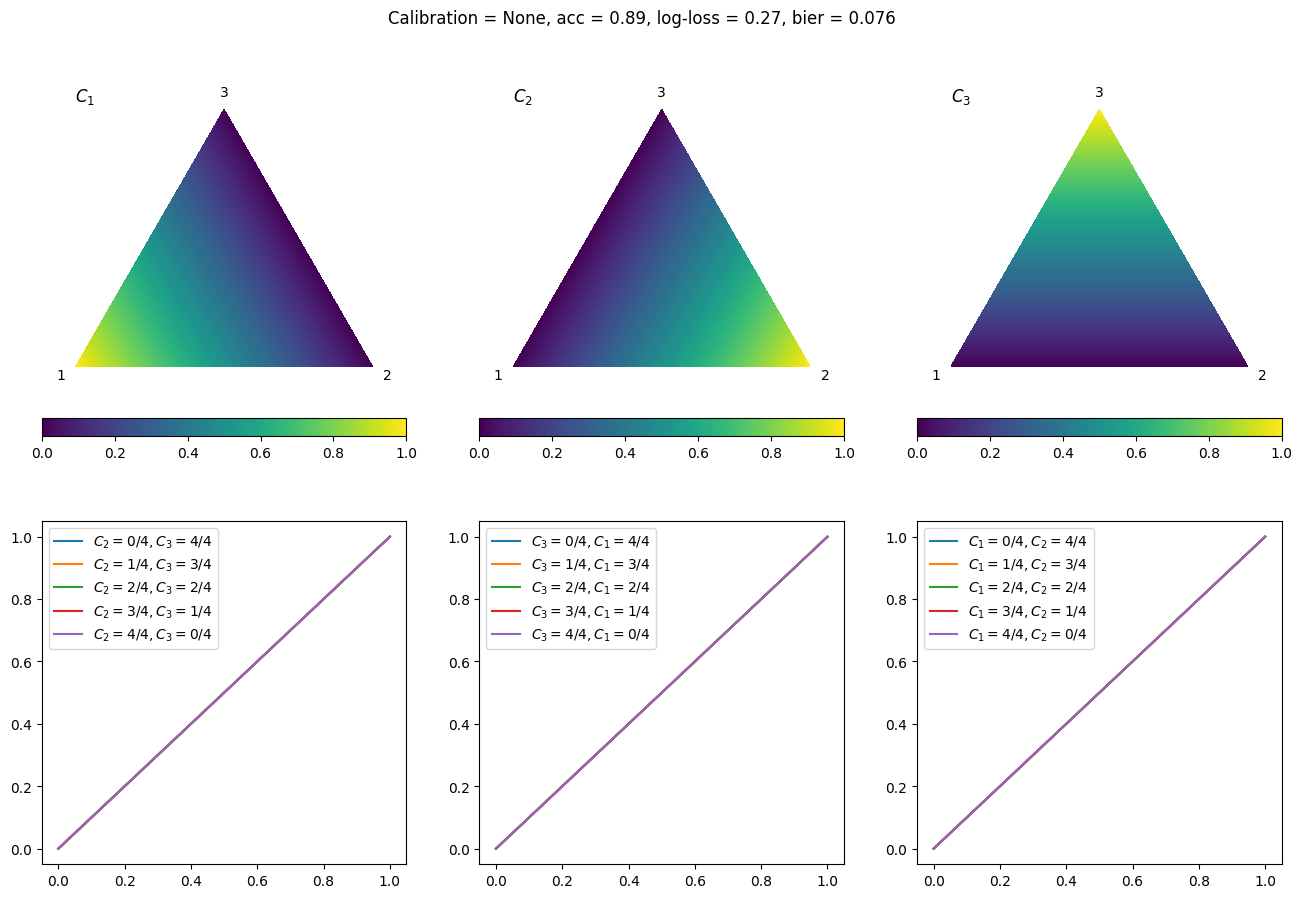

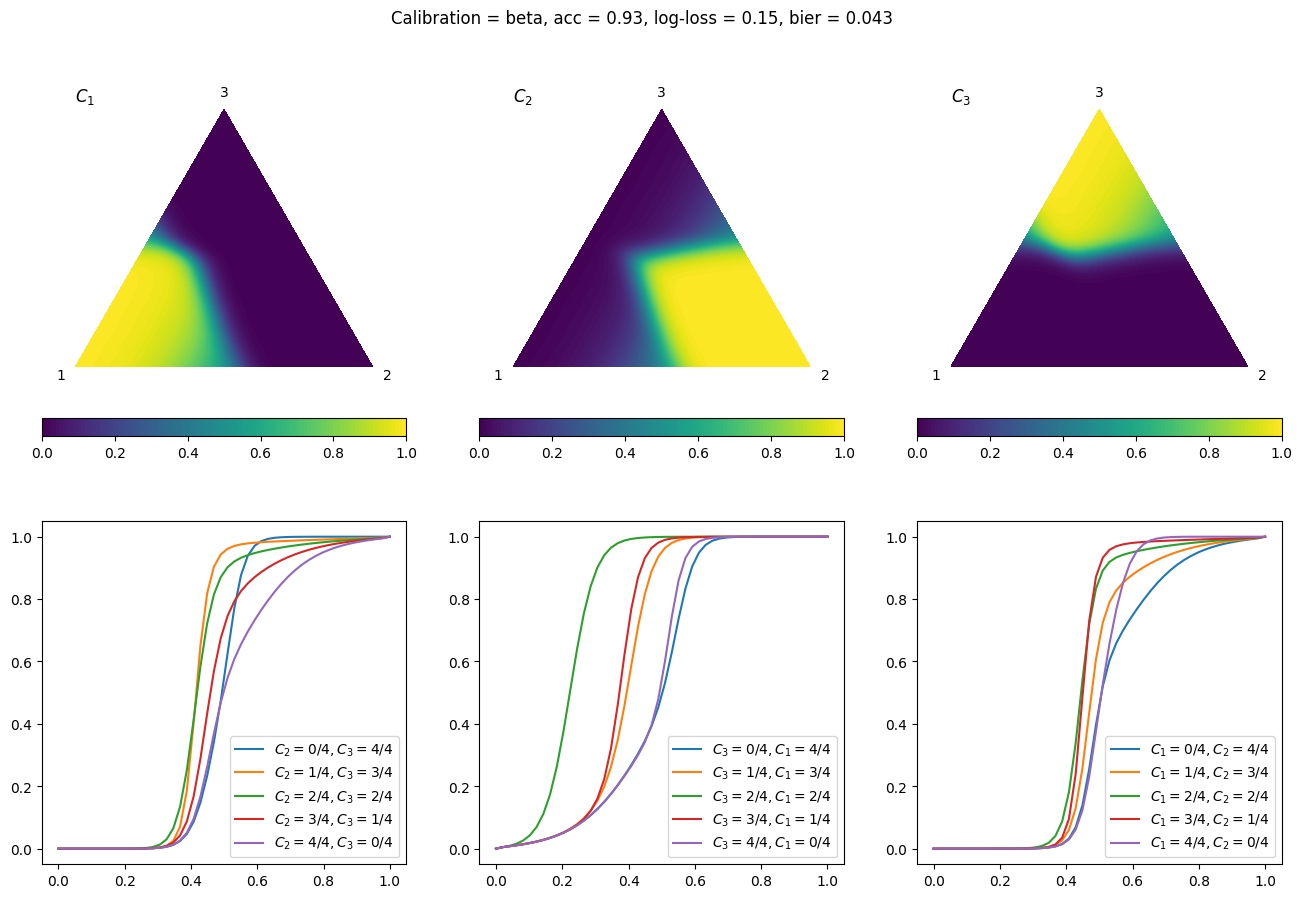

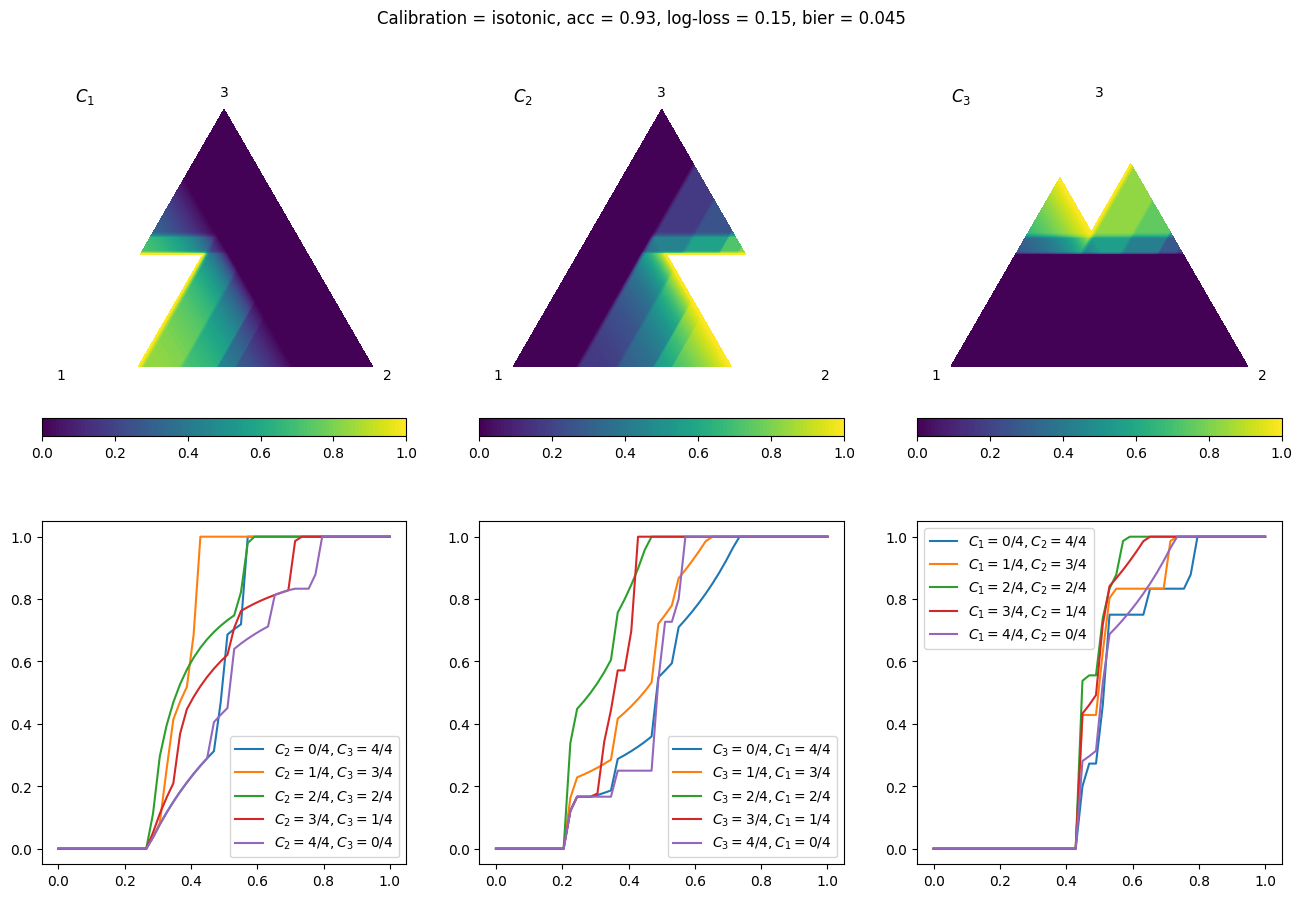

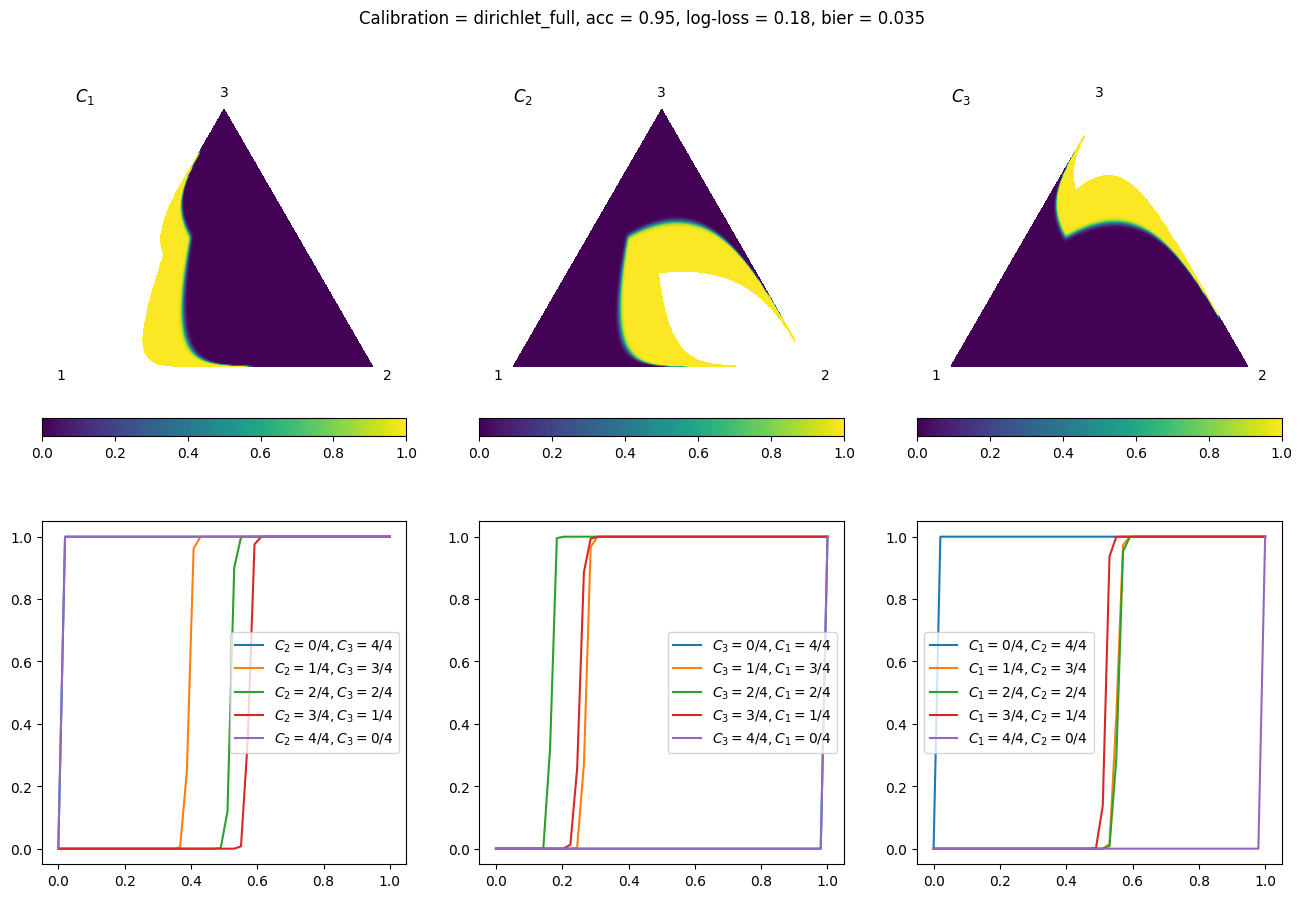

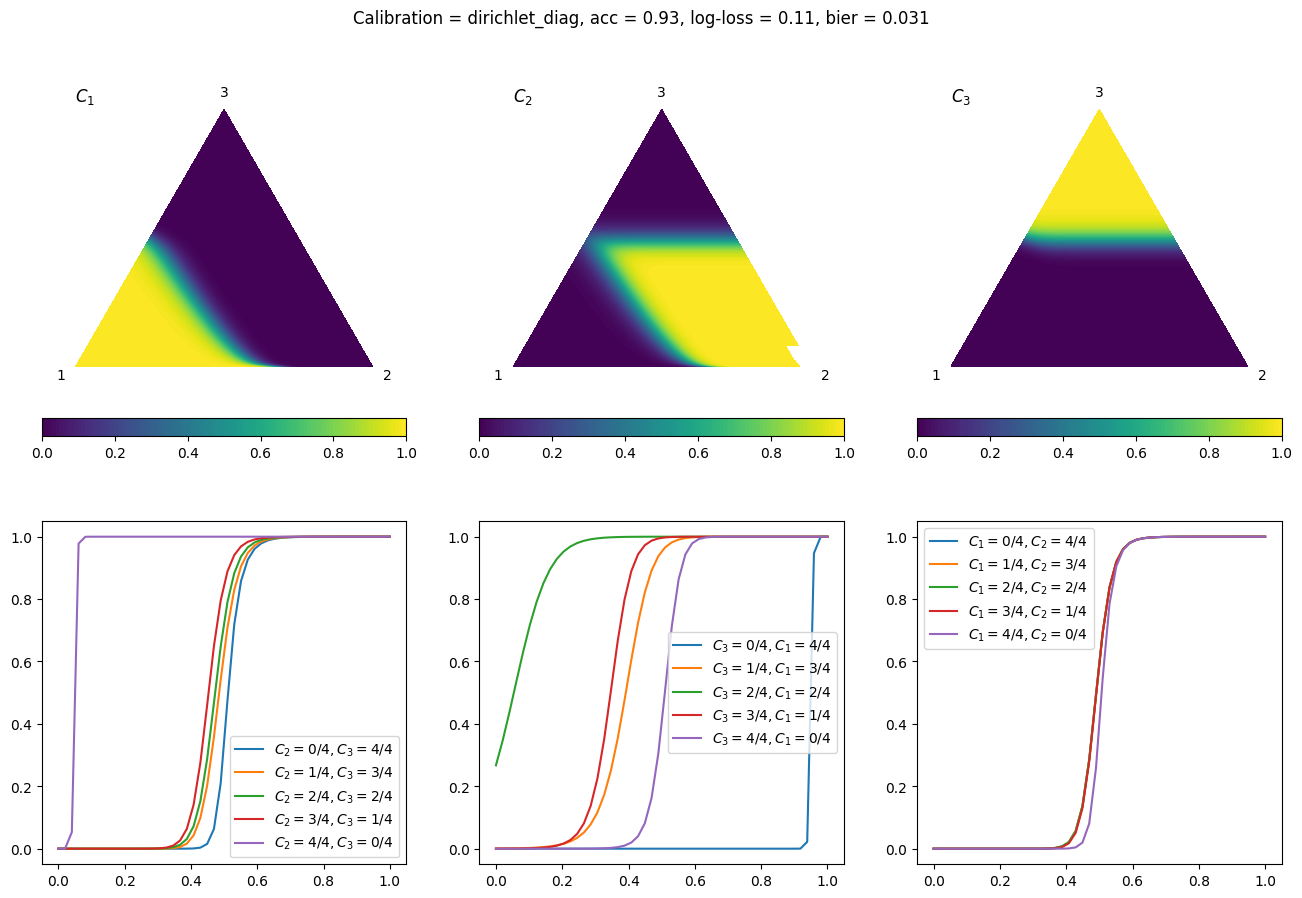

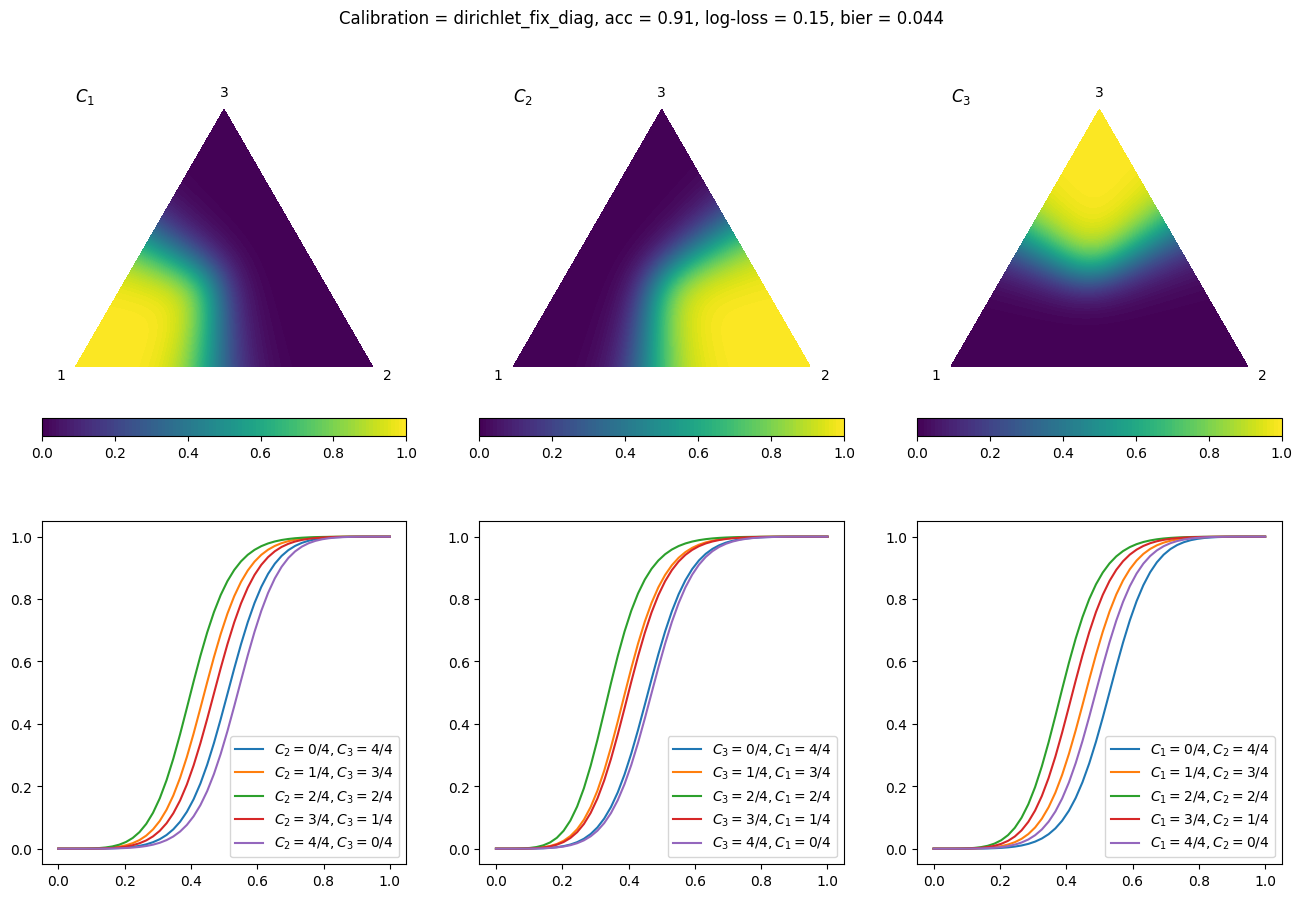

In [33]:
for method in methods:
    calibrator = cl[method][0].calibrator
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Calibration = {}, acc = {:.2}, log-loss = {:.2}, bier = {:.2}'.format(
        method, accs[method], losses[method], briers[method]))
    for i, c in enumerate(['C1', 'C2', 'C3']):
        ax = fig.add_subplot(2, 3, i+1)

        ax.set_title('$C_{}$'.format(i+1), loc='left')

        function = lambda x: calibrator.predict_proba(x.reshape(1,-1))[0][i]
        draw_func_contours(function, labels=dataset.names, fig=fig, ax=ax, nlevels=nlevels, subdiv=subdiv)
        
        ax2 = fig.add_subplot(2, 3, 3+i+1)
        lines = get_converging_lines(num_lines=5, mesh_precision=50, class_index=i)
        plot_converging_lines_pvalues(function, lines, i, ax2)

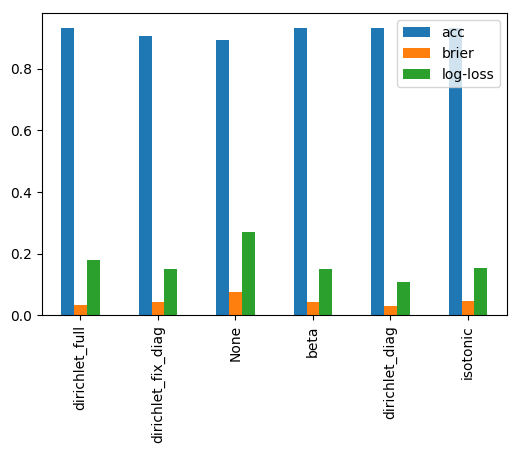

In [16]:
import pandas as pd
import numpy as np
results = {'log-loss': losses,
           'acc': accs,
           'brier': briers}
values = np.zeros((len(results.values()[0]), len(results)))
for i, key_i in enumerate(results.values()[0].keys()):
    for j, key_j in enumerate(results.keys()):
        values[i,j] = results[key_j][key_i]
df = pd.DataFrame(values, index=results.values()[0].keys(), columns=results.keys())
df.plot(kind='bar')